# Курс "Практикум по математической статистике"

# 3 курс ФПМИ МФТИ, осень 2025
## Практическое задание 2. Доверительное оценивание, бутстреп, робастные методы
### Дедлайн --- 18 октября, 16:00

Это обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Сдавать ноутбук нужно будет в LMS.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.



In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as sps
import scipy.optimize as spo
from scipy.special import gammaln, digamma
from scipy.integrate import quad

from matplotlib import pyplot as plt
import seaborn as sns

# from joblib import Parallel, delayed

sns.set(style="darkgrid", font_scale=1.4)

seed = 42

**Дисклеймер**:
В задачах будет разбиение на пункты, но оцениваться задача будет **целиком**. Можете считать, что выполнение всех пунктов вместе с отсутствием замечаний по полноте анализа/эффективности кода/информативности графиков/т.д. приносит полный балл.

## Задача 1

В случаях, когда ошибка в значении параметра может дорого обойтись, применяют доверительное оценивание. Вместо точечного значения параметра оценкой является отрезок, который с высокой вероятностью накрывает истинное значение параметра. Эту вероятность ещё называют *уровнем доверия*. В рамках этого ноутбука установим его равным $\gamma = 0.95$.

В этой задаче мы посмотрим на разные подходы в построении ДИ.

- В каждом из пунктов ниже сгенерируйте выборку $X_1, ...,X_{100}$ из распределения $\mathsf P_\theta$. Для уровня доверия $\gamma$ и всех $n \leq 100$ изобразите на графиках в координатах $(n, \theta)$:
    - Доверительный интервал для параметра $\theta$. Его нужно построить по первым $n$ элементам выборки, теоретически обосновать и написать;
    - График оценки $\widehat{\theta}_n$;
    - Истинное значение параметра $\theta$.

- Для отрисовки доверительного интервала используйте `plt.fill_between`. Не забудьте про параметр `alpha`.

- Для того, чтобы избежать дублирования кода, рекомендуем написать функцию `draw_confidence_interval`, изображающую на графике все необходимое.

- В каждом случае при помощи моделирования проверьте, как часто параметр действительно попадает в свой доверительный интервал: сгенерируйте $n$ (чему равно $n$ -- см. ниже) выборок размера 100, по каждой из них постройте доверительный интервал и проверьте, накрыли ли в очередной раз параметр или нет. Таким образом, мы получим выборку из $\mathrm{Bern}(p)$ размера $n$, где $p$ --- истинная вероятность накрытия (которая может немного отличаться от взятой $\gamma$). В свою очередь для правильного оценивания $p$ мы тоже можем построить ДИ. Для этого перед началом выполнения пунктов:
    - Выпишите асимптотический ДИ у.д. $\gamma$ для параметра $p$, используя выборочное среднее как асимптотически нормальную оценку. Для удобства оформите вычисление этого ДИ в виде функции `confint_bern(k, n)`, где `k` --- число попаданий в ДИ.
    - Нам хотелось бы, чтобы полученный при моделировании интервал для $p$ был не слишком большим. Договоримся, чтобы его радиус не превышал $0.01$. Какое минимальное $N$ надо взять, чтобы наши хотелки были **гарантировано** удовлетворены? Найдите его и используйте именно это значение для числа выборок.
    - Полученный для $p$ интервал впишите в название графика.

In [ ]:
GAMMA = 0.95

def draw_confidence_interval(n, conf_int, theta_hat, true_mean, theta_hat_label, com_label):
    plt.figure(figsize=(9,18))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    n_range = np.arange(1, n+1)

    fig.suptitle(com_label)

    [ax1.plot(n_range, conf_int[i] - true_mean, lw=2, color="red", alpha=1, label=r"_") for i in [0,1]]
    ax1.fill_between(n_range, conf_int[0] - true_mean, conf_int[1] - true_mean, lw=2, color="red", alpha=0.1, label=r"_")
    ax1.set_xlabel(r"$n$"); ax1.set_yscale("symlog"); ax1.set_ylabel(r"$\theta$"); ax1.set_title(r"Довеотнормированныйрительный интервал для параметра $\theta$," + "\n" + " к 0")

    ax2.plot(n_range, theta_hat, lw=2, color="red", alpha=1, label=r"_")
    ax2.axhline(true_mean, lw=2, color="green", ls="--", alpha=1, label=r"_")
    ax2.set_xlabel(r"$n$"); ax2.set_ylabel(r"$\hat{\theta}$"); ax2.set_title(r"Значение оценки " + theta_hat_label)

    plt.show()

<font color="#ae69c9ff">

В явном виде найдём доверительный интервал для распределения Бернулли

По ЦПТ: $\sqrt{n}(\overline{X} - p) \rightarrow N(0, p(1-p))$

$\frac{\sqrt{n}(\overline{X} - p)}{\sqrt{\overline{X} (1-\overline{X})}} \rightarrow N(0,1)$

Так как по заданию нас просят гарантированный случай, рассмотрим хуший случай: $\overline{X} (1-\overline{X}) = 1/4$

$P(\overline{X} + \frac{z_{0.025}}{2\sqrt{n}} < p < \overline{X} - \frac{z_{0.025}}{2\sqrt{n}}) \rightarrow 0.95$

Тогда хотим: $\frac{z_{0.025} \cdot 2}{2 \cdot 2\sqrt{n}} = 0.01$, что будет верно при $n = (\frac{z_{0.025}}{0.02})^2 = (\frac{-1.96}{0.02})^2 = 9604$

In [ ]:
def confint_bern(k, n):
    return fr"$P({k / n - 1.96 / 2 / n ** 0.5 :0.4f} \leq p \leq {k / n + 1.96 / 2 / n ** 0.5 :0.4f}) \rightarrow 0.95$, где $p$ - вероятность попадания оценки в интервал для $n = 100$"

1. $\mathsf{P}_{\theta} = \mathrm{U}[0, \theta]$.
- В качестве истинного значения параметра возьмите $\theta = 10$.
- ДИ постройте [методом центральной статистики](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0) посредством оценки $\widehat{\theta} = \frac{n+1}{n}X_{(n)}$.
- Дополнительно объясните, зачем нужен множитель $\frac{n+1}{n}$ и почему на графике не стоит рисовать оценку $\widetilde{\theta} = X_{(n)}$.

<font color="#ae69c9ff">

Хотим: Ц.С - $\varphi (\frac{n+1}{n} X_{(n)})$, рассмотрим $\varphi (\frac{n+1}{n} X_{(n)}) = \frac{n+1}{n} X_{(n)} / \theta$

$F_{\frac{n+1}{n} X_{(n)}} (t) = P(\frac{n+1}{n} X_{(n)} \leq t) = \frac{tn \cdot \theta}{(n+1) \cdot \theta}$

Пусть $u_p$ - статистика порядка $p$ для получившегося распределения, тогда: $p = (\frac{u_p n}{n+1})^n \rightarrow u_p = p^{\frac{1}{n}} \frac{n+1}{n}$

$P(u_{\frac{1-0.95}{2}} \leq \frac{n+1}{n} X_{(n)} / \theta \leq u_{\frac{1+0.95}{2}}) = 0.95$

$P(\frac{X_{(n)}}{0.025^{\frac{1}{n}} \frac{n+1}{n}} \leq \theta \leq \frac{X_{(n)}}{0.975^{\frac{1}{n}} \frac{n+1}{n}}) = 0.95$

\
Выбор множителя перед оценкой обусловлен тем, что $\frac{n+1}{n} X_{(n)}$ является несмещённой оценкой (см. книгу Андрея / ходи на семинары по матстатам) $\rightarrow$ удаётся достичь меньшей ошибки

Вообще, здесь интервал выбран не оптимально, ибо интересующая нас оценка имеет что-то в роде экспоненциального распределения (я не знаю, вывод сделан по графикам первого прака), но мы пока не будем беспокоиться на эту тему

<Figure size 900x1800 with 0 Axes>

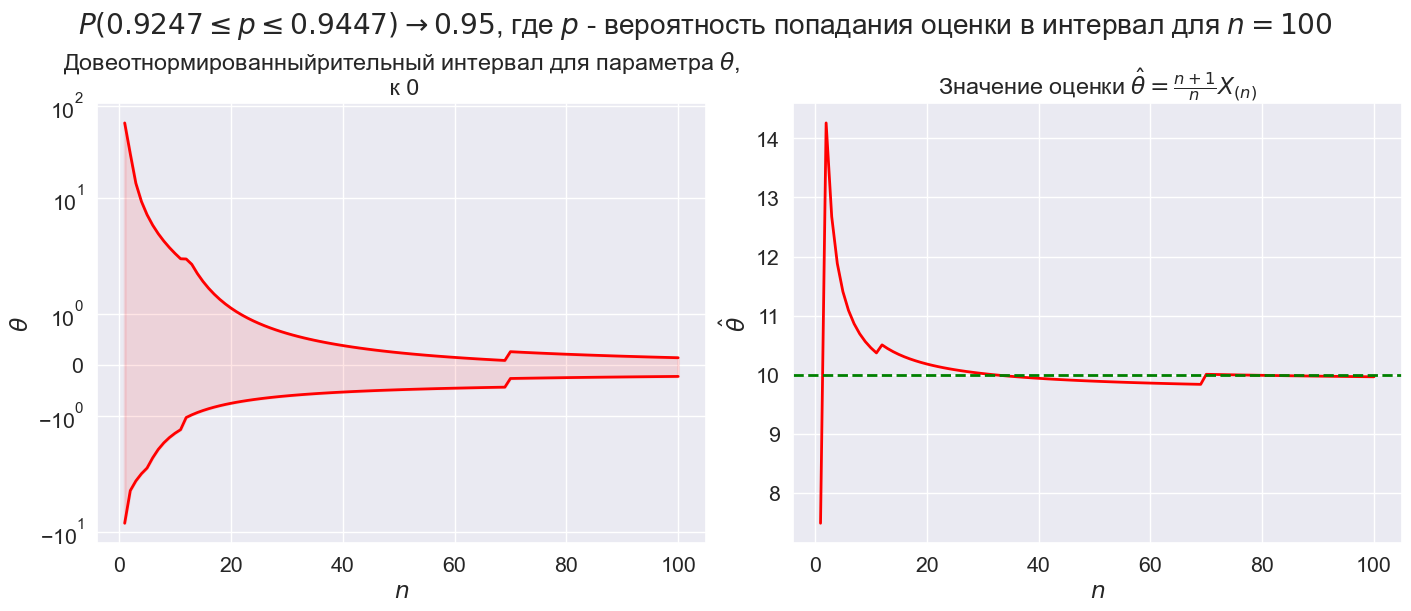

In [ ]:
THETA = 10
N = 9604
n = 100

X = sps.uniform(0, THETA).rvs(n, random_state=seed)
n_range = np.arange(1, n + 1)
conf_int = [np.maximum.accumulate(X) / (0.025 ** (1 / n_range) * (n_range + 1) / n_range),
              np.maximum.accumulate(X) / (0.975 ** (1 / n_range) * (n_range + 1) / n_range)]
theta_hat = (n_range + 1) / n_range * np.maximum.accumulate(X)

samples = sps.uniform(0, THETA).rvs((N, n), random_state=seed)
conf_int_samples = [np.max(samples, axis=1) / (0.025 ** (1 / n) * (n + 1) / n),
              np.max(samples, axis=1) / (0.975 ** (1 / n) * (n + 1) / n)]
k = np.sum((conf_int_samples[1] <= THETA) & (THETA <= conf_int_samples[0]))

draw_confidence_interval(n, conf_int, theta_hat, THETA, r"$\hat{\theta} = \frac{n+1}{n}X_{(n)}$", confint_bern(k, N))

<font color='green'>
Какой-какой интервал?..
</color>

<font color='red'>
Тут стоило оценку изобразить вместе с её доверительным интервалом (ну то есть интервал должен как трубка идти вокруг графика оценки), а так непонятно, попадает ли θ в интервал или нет
<b><br>
Штраф 1 балл
</color>

<font color="#ae69c9ff">

Ну, собственно, как я и упомянул выше, доверительный интервал выбран не лучшим образом. А так на графиках видна достаточно быстрая (скорости примерно 1/n, достаточно разложить $\exp(\ln{0.025} / n)$, как $1 - \frac{\ln{0.025}}{n} + O(n^{-2})$, чему учили ещё в советских яслях) сходимость как границ интервала, так и оценки к желаемым/истинным значениям

2. $\mathsf P_{\theta, \sigma^2} = \mathcal{N}(\theta, \sigma^2)$.
- Здесь **оба параметра $\theta, \sigma^2$ неизвестны**, но ДИ строим для $\theta$.
- $\theta$ --- параметр сдвига, $\sigma^2$ --- дисперсия.
- В качестве истинного значения параметров возьмите $\theta = 10$, $\sigma^2 = 9$.
- ДИ постройте точный, с помощью статистики Стьюдента (см. ноутбук с лекции, теоретически обосновывать его не нужно). Для графика возьмите $\widehat{\theta} = \overline{X}$.

<font color="#ae69c9ff">

Выпишем интервал в явном виде:
$$
\left(\overline{X} - \frac{t_{n-1,(1+\gamma)/2} \cdot \sqrt{\widehat{\sigma}^2}}{\sqrt{n}}, \overline{X} + \frac{t_{n-1,(1+\gamma)/2} \cdot \sqrt{\widehat{\sigma}^2}}{\sqrt{n}}\right)
$$

<Figure size 900x1800 with 0 Axes>

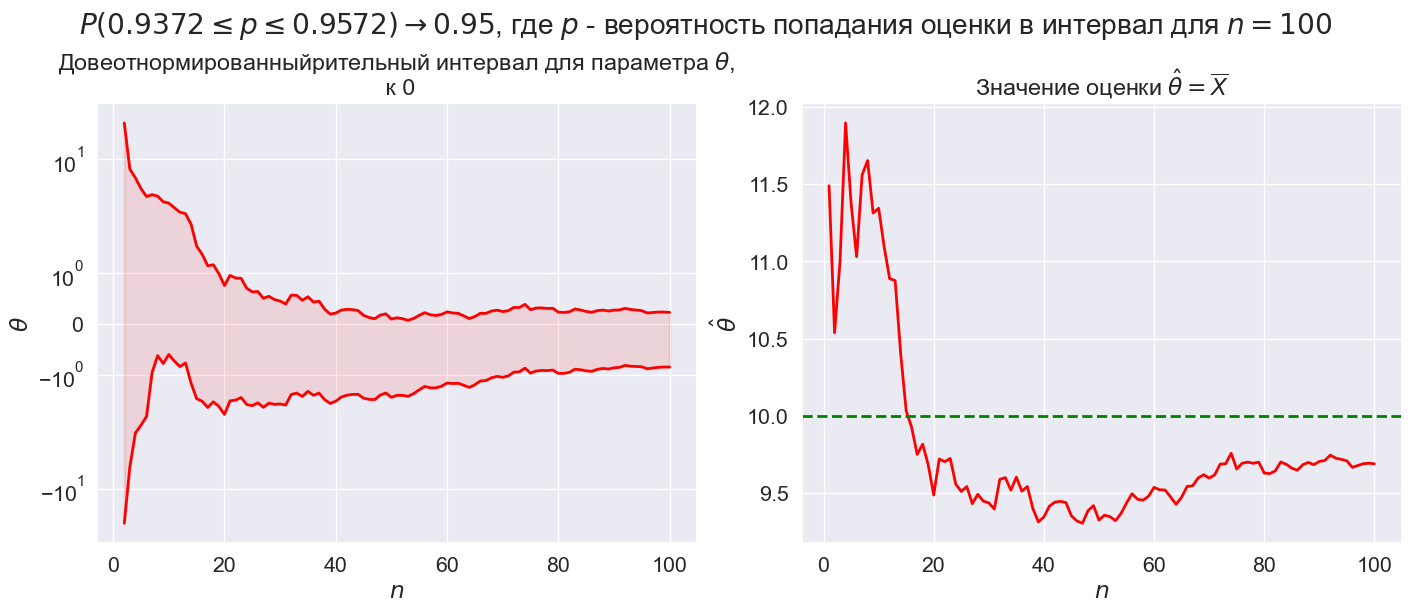

In [ ]:
THETA = 10
SIGMA = 3
N = 9604
n = 100

X = sps.norm(THETA, SIGMA).rvs(n, random_state=seed)
n_range = np.arange(1, n + 1)
conf_int = [np.cumsum(X) / n_range - (sps.t.ppf(0.025, df=n_range-1) * np.std(X, ddof=1) / n_range ** 0.5),
            np.cumsum(X) / n_range + (sps.t.ppf(0.025, df=n_range-1) * np.std(X, ddof=1) / n_range ** 0.5)]
theta_hat = np.cumsum(X) / n_range

samples = sps.norm(THETA, SIGMA).rvs((N, n), random_state=seed)
conf_int_samples = [np.mean(samples, axis=1) - (sps.t.ppf(0.025, df=n-1) * np.std(samples, ddof=1, axis=1) / n ** 0.5),
                    np.mean(samples, axis=1) + (sps.t.ppf(0.025, df=n-1) * np.std(samples, ddof=1, axis=1) / n ** 0.5)]
k = np.sum((conf_int_samples[1] <= THETA) & (THETA <= conf_int_samples[0]))

draw_confidence_interval(n, conf_int, theta_hat, THETA, r"$\hat{\theta} = \overline{X}$", confint_bern(k, N))

<font color="#ae69c9ff">

Доверительный интервал взят с ноутбука, выборочную дисперсию я посчитал готовой формулой.

Для данной оценки параметров распредлеения скорость сходимости оказалась меньше (примерно $\frac{1}{\sqrt{n}}$, тут просто очев из знаменателя), отсюда и менее галдкие графики, более чувствительные к выбросам)

3. $\mathsf P_{\theta, \lambda} = \Gamma(\theta, \lambda)$.
- Здесь **оба параметра $\theta, \lambda$ неизвестны**, но ДИ строим для $\theta$.
- Параметризация как в правом столбце в [Википедии](https://en.wikipedia.org/wiki/Gamma_distribution?ysclid=mefohahyxl329612880): $\theta$ --- параметр формы, $\lambda$ --- параметр интенсивности.
- В качестве истинного значения параметров возьмите $\theta = 10$, $\lambda = 4$.
- ДИ постройте с помощью асимп. нормальной оценки, а именно --- ОМП, $\widehat\theta = \widehat\theta_{MLE}$.
    - В прошлом праке вы уже научились находить ОМП численно, а из основного курса узнаете, что асимп. ковариационная матрица ОМП равна обратной матрице Фишера:
    $$
    \sqrt{n} \cdot (\widehat\theta_{MLE} - \theta) \stackrel{d}{\to} \mathcal{N}(0, I(\theta)^{-1}),$$

$$
I(\theta)_{ij} = -\mathsf E_{\theta} \frac{\partial^2}{\partial \theta_i \partial \theta_j} \ln \rho_{\theta}(X_1), \;\;\; \theta = (\theta_1, \ldots, \theta_k) \text{ --- вектор параметров}
$$
Поймите, чем можно приблизить обратную матрицу Фишера и как всё это дело посчитать численно. Возможно, функция [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) вам поможет.
- Дополнительно поясните, почему мы не воспользовались какими-то более простыми асимп. нормальными оценками, например, по методу моментов. В чём польза использования именно ОМП?

<font color="#ae69c9ff">

Чего-то я забыл про последний пункт, отвечу здесь: 1. с семинара мы знаем, что ОМП для распределений экспоненциального семейства достигает равенства в неравенстве Рао-Крамера -> оценка наилучшая. Кроме того, после просмотра записи доп. семинара Степана Платинского (тоже легенда, тоже спасибо за детство!), мы знаем, что _скорее всего_ оценка, полученная по ММП, будет ещё ас. норсальна -> состоятельна.

А ещё выпишем доверительный интервал, который будем строить далеее (корректность прокомментирую ниже):
$$
\left( \hat\theta - z_{0.975} \sqrt{H(\hat\theta, \hat\lambda)^{-1}_{11}} ,\  \hat\theta + z_{0.975} \sqrt{H(\hat\theta, \hat\lambda)^{-1}_{11}}\right)
$$


In [ ]:
def p(theta, x):
    t = np.asarray(theta).ravel()
    return np.exp(t[0]*np.log(t[1]) - gammaln(t[0]) + (t[0]-1)*np.log(x) - t[1]*x)

def dp(theta, x):
    t = np.asarray(theta).ravel()
    # _на стене в болтае_ было написано, что можно совершить 300iq мув: посчитать производную log(p) и домножить её на p
    # это действие спасёт меня от взятия производной плотности гамма распределения руками (круто!!)
    dlog_dth = np.log(t[1]) + np.log(x) - digamma(t[0])
    dlog_dla = t[0] / t[1] - x
    return p(t, x) * np.array([dlog_dth, dlog_dla])

def f(theta, X):
    t = np.asarray(theta).ravel()
    return -sum([np.log(p(t, x)) for x in X]), dl(t, X)

def dl(theta, X):
    t = np.asarray(theta).ravel()
    ans = np.zeros((X.size, 2))
    for i in range(X.size):
        ans[i] = dp(t, X[i]) / p(t, X[i])
    return -np.sum(ans, axis=0)

<font color='green'>
Нуу, для квазиньютона якобиан по идее не обязательно было считать
</color>

In [ ]:
LAMBDA = 4
n = 10000
sample = sps.gamma(a=THETA, scale=1/LAMBDA).rvs(n, random_state=seed)
print(spo.minimize(fun=f, jac=True, args=(sample,), x0=np.array([15, 10]), bounds=[(1e-6,None),(1e-6,None)]).x)

n = 1000
X = sps.gamma(a=THETA, scale=1/LAMBDA).rvs(n, random_state=seed)
res = spo.minimize(fun=f, jac=True, args=(X,), x0=np.array([15, 10]), bounds=[(1e-6,None),(1e-6,None)])

theta_hat, lambda_hat = res.x
I_inv = res.hess_inv.todense()
print(res.x)

[10.25122125  4.07647603]
[10.58751863  4.1637252 ]


<Figure size 900x1800 with 0 Axes>

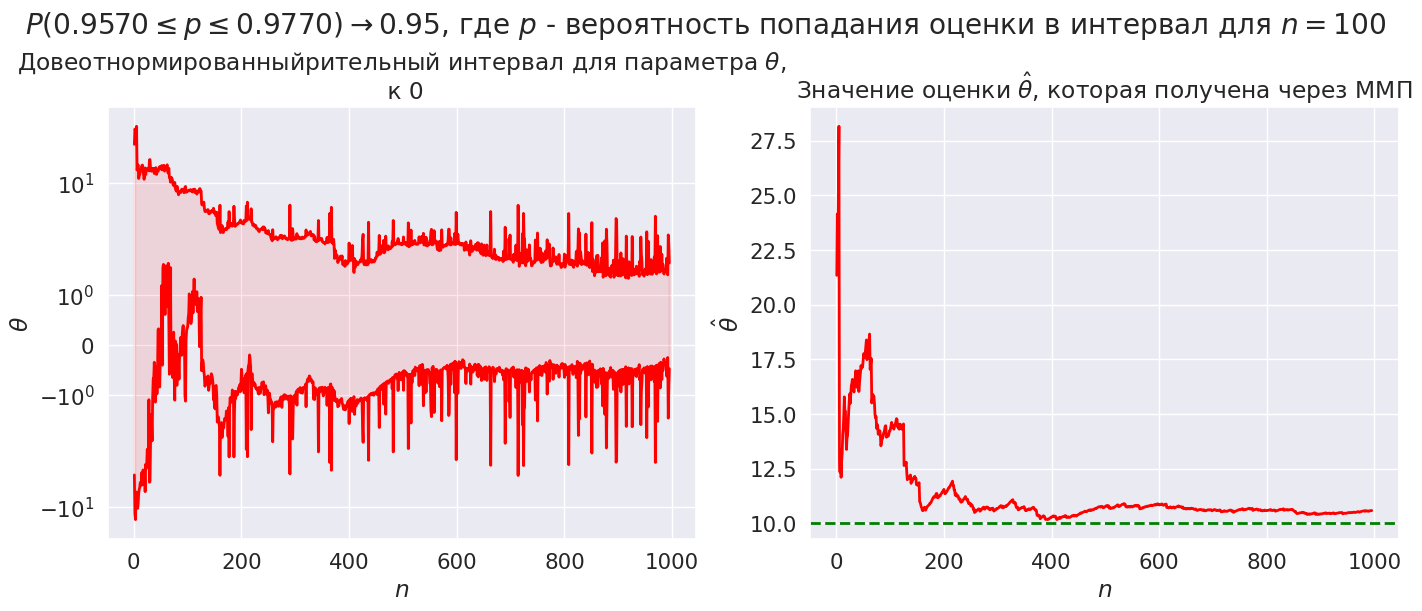

In [ ]:
n = 1000 # на n = 100 сходимость видна плохо, мне не нравится. Т.к. время бесплатное, я хочу сделать для 1000

start_points = sps.uniform(0, 30).rvs(n, random_state=seed) # внесём какую-то случайность в стартовые позиции, интуиция говорит: это хорошо
res_X = [spo.minimize(fun=f, jac=True, args=(X[:i],), x0=np.array([start_points[i], start_points[i]]), bounds=[(1e-6,None),(1e-6,None)]) for i in range(n)[5:]]
theta_hat = np.array([res.x[0] for res in res_X])
I_inv_X = np.array([res.hess_inv.todense()[0, 0] for res in res_X])
conf_int = [theta_hat - (sps.norm.ppf(0.025) * I_inv_X ** 0.5),
            theta_hat + (sps.norm.ppf(0.025) * I_inv_X ** 0.5)]

samples = sps.gamma(a=THETA, scale=1/LAMBDA).rvs((N, n), random_state=seed)
start_points = sps.uniform(0, 30).rvs(N, random_state=seed)
res_samples = [spo.minimize(fun=f, jac=True, args=(samples[i],), x0=np.array([start_points[i], start_points[i]]), bounds=[(1e-6,None),(1e-6,None)]) for i in range(N)]
theta_hat_samples = np.array([res.x[0] for res in res_samples])
I_inv_X_samples = np.array([res.hess_inv.todense()[0, 0] for res in res_samples])
conf_int_samples = [theta_hat_samples - (sps.norm.ppf(0.025) * I_inv_X_samples ** 0.5),
                    theta_hat_samples + (sps.norm.ppf(0.025) * I_inv_X_samples ** 0.5)]
k = np.sum((conf_int_samples[1] <= THETA) & (THETA <= conf_int_samples[0]))

draw_confidence_interval(n-5, conf_int, theta_hat, THETA, r"$\hat{\theta}$, которая получена через ММП", confint_bern(k, N))

<font color='red'>
Я верю, что в первый раз нам просто не повезло и γ не попала в интервал, но второй раз это уже подозрительно... <br>Ну да, у вас <code>confint_bern</code> не учитывает асимптотическую дисперсию, которая тоже через k считается
<b><br>
Штраф 1 балл
</color>

<font color="#ae69c9ff">

ММП даёт плохую оценку параметров на малых выборках, однако даже при малом n видна скорость сходимости в $1/\sqrt{n}$. Итог по пункту задания - узнали крутой метод оценки распределения с двумя неизвестными параметрами.

Ещё пара слов про корректность, мне было не очевидно. .minimize вернёт гессиан в точке, что есть $\sum_{i=1}^n -\Delta L(\theta, X_i)$, а нас интересует $-E_{\theta}\nabla l(X)$, применив ЗБЧ и разделив первую на n, получим: разность упомянутых выше функций по вероятности стремится к 0. Сходимости по вероятности хватит, так как дальше мы сюда применим теорему о наследовании сходимостей и лемму Слуцкого, чтобы перенести дисперсию "вниз". И да, для перехода от многомерной ас. нормальности оценки к одномерному распредлению применяем давнео теорему: если есть слабая сходимость векторов, то есть и слабая покоорд. сходимость. Ну, собственно, победа.\
Оговорка: Пропадёт $\sqrt{n}$ в знаменателе при подсчёте ДИ

P.S. Блин, тут ячейка считалась 36 минут. Я прогнал её вчера вечером, а в 3 ночи на кампусе выключили свет. Всё бы фигня, но перезапустить не успею

👍

Сделайте вывод о том, насколько точен доверительный интервал в каждом случае? Насколько он широк? А что от него ожидается: быть шире или быть уже? От каких свойств распределения зависит ширина?

<font color="#ae69c9ff">

В первом случае к длине интервала вопросов нет (оценка точная), во втором же оценка асимптотическая, но сходимость нужной скорости всё равно проглядывается, не смотря на малое n. В третьем же случае наблюдается скорее намёк на сходимость. Ошибка появляется на двух этапах: ММП, сошенность исходного распредлеения и ас. длина интервала.

Что здорово (ура, задание выполнено верно!), пусть интервалы и желаемы/великоваты, они очень хорошо накрывают истинное значение параметра.

<font color='green'>
<b>Итог: 8 баллов
</color>

## Задача 2. Бутстреп



На лекции мы с горем пополам научились строить бутстрепные ДИ, давайте теперь поймём, какие из них более точны. В этом пункте вы будете строить различные ДИ для корня из дисперсии a.k.a стандартного отклонения (std); вам предлагается моделированием оценить вероятность накрытия ими истинного значения std распределения в зависимости от размера выборки. Вот примерный план:
- Выберете сами распределение, которое на ваш взгляд будет достаточно репрезентативным в контексте сравнения ДИ для std. Поясните ваш выбор. *Замечание.* Давайте договоримся, что у выбранного вами распределения будут существовать и конечны все моменты ($\mathsf{E} |\xi|^k < \infty$, $k \in \mathbb{N}$): будет странно оценивать то, чего у распределения нет.

In [ ]:
distr = sps.gamma(a=THETA, scale=1/LAMBDA)
# Я выбрал кси-квадрат распредлеение, так как интересно посмотреть, как ДИ, построенные неиже, работают с хвостами распредлеения разного размера.
# Интуиция: чем "кривее" распределение, тем сложнее для него написать сколь угодно точные оценки

<font color='red'>
Оно хи-квадрат всё же
</color>

- Создадим сетку из размеров выборки, для которых будем строить интервалы. Вы вольны менять её размер и шаг, если от этого не пострадает общая картина происходящего.

In [ ]:
n = 500
sample_size_grid = np.arange(25, n + 1, 25)

- Сгенерируем много выборок большого размера. Далее при построении ДИ для разных размеров выборки мы будем просто брать префиксы и считать ДИ по ним. А вас попросим посчитать **истинное (то есть теоретическое)** значение std с помощью scipy, надеюсь, вас это не затруднит.

In [ ]:
true_theta = distr.std()

samples_num = n
samples = distr.rvs(size=(samples_num, np.max(sample_size_grid)), random_state=seed)

- Теперь самое интересное: напишите функцию, которая по выборке и истинному значению оцениваемого параметра проверяет, правда ли доверительные интервалы его накрывают, а также считает их длину. Мы будем сравнивать следующие бутстреповские интервалы:
    - Нормальный ДИ, основанный на бутстреповской оценке дисперсии;
    - Перцентильный ДИ;
    - $BC_a$-интервал (bias-corrected and accelerated) --- более крутая версия перцентильного интервала, чья скорость сходимости истинного уровня доверия к теоретическому выше.

- Для подсчёта можете воспользоваться библиотечными реализациями, например, [scipy.stats.bootstrap](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html), но за доп. 5 баллов можете сами написать подсчёт $BC_a$ (для этого можно почитать [статью](https://2024.sci-hub.ru/2881/cc14d0fd5df5d3c017fdbea4c7a56a7e/efron1987.pdf?download=true), а уточнения писать в чате). Внимательно изучите её ввод и вывод, возможно, это поможет вам не считать кучу раз одно и то же.

In [ ]:
def check_ci(X, true_theta, B=10000, stat=np.std):
    boot_samples = np.random.choice(X, size=(B, X.size))
    boot_stats = stat(boot_samples, axis=1, ddof=1)

    theta_hat = np.std(X)
    var_boot = np.var(boot_stats)
    z_p = sps.norm.ppf((1 + GAMMA) / 2)
    conf_int_norm = [theta_hat - z_p * var_boot ** 0.5, theta_hat + z_p * var_boot ** 0.5]

    conf_int_perc = np.percentile(boot_stats, [2.5, 97.5])

    tmp = sps.bootstrap(data=(X,), statistic=lambda st: np.std(st, ddof=1), confidence_level=0.95, n_resamples=B, method="BCa", axis=0, random_state=seed).confidence_interval
    conf_int_BCa = [tmp.low, tmp.high]

    return ([np.sum(conf_int_norm[0] <= true_theta <= conf_int_norm[1]), np.sum(conf_int_perc[0] <= true_theta <= conf_int_perc[1]), np.sum(conf_int_BCa[0] <= true_theta <= conf_int_BCa[1])],
            [np.mean(conf_int_norm[1] - conf_int_norm[0]), np.mean(conf_int_perc[1] - conf_int_perc[0]), np.mean(conf_int_BCa[1] - conf_int_BCa[0])])

- Для каждого размера выборки из `sample_size_grid` запустите `samples_num` раз функцию выше для выборок, которые мы посчитали ранее. Учтите, что это может занять приличное время. Присмотритесь к возможности запустить подсчёт параллельно, например, посредством [`joblib.Parallel`](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html). В ячейке ниже приведён некоторый пример того, как можно агрегировать возвращаемые функцией `check_ci` значения, но вы вольны менять формат функции и её ввод/вывод без изменения содержательной части, если вам будет удобнее.

- Визуализируйте полученные результаты: нарисуйте графики вероятности накрытия и средней длины интервалов. Не забудьте с помощью `plt.fillbetween` нарисовать ДИ для вероятностей накрытия, для его вычисления можете воспользоваться функцией, написанной вами в прошлой задаче.

In [ ]:
rejects = np.zeros((sample_size_grid.size, 3)) # rejects[i][j] = среднее число интервалов вида j, построенных по выборкам X[:, :sample_size_grid[i]], которые не накрыли true_theta
lengths = np.zeros((sample_size_grid.size, 3)) # lengths[i][j] = средняя длина интервалов вида j, построенных по выборкам X[:, :sample_size_grid[i]]
# j = 0 -- нормальный ДИ, j = 1 -- перцентильный ДИ, j = 2 -- BCa-интервал

def f(sample_size):
    samples_short = samples[:, :sample_size]  # префиксы длины n для всех имитаций
    rej_acc = np.zeros(3)
    len_acc = np.zeros(3)
    for X in samples_short:
        cover, lens = check_ci(X, true_theta, B=10000, stat=np.std)
        rej_acc += np.array(cover, dtype=float)
        len_acc += np.array(lens, dtype=float)
    return rej_acc / len(samples_short), len_acc / len(samples_short)

ans = Parallel(n_jobs=-1, backend="loky")(delayed(f)(n) for n in sample_size_grid)

rejects = np.asarray([o[0] for o in ans])
lengths  = np.asarray([o[1] for o in ans])

<font color='green'>
Хорош кстати, обычно люди до n=150 еле досчитывают
</color>

In [ ]:
rejects -= GAMMA # Я искреене считаю, что это хорошее решение. Таким образом можно добиться логарифмической шкалы при построении за бесплатно, что круто для читаемости
# Окак, а она здесь и не нужна. Ну, ладно, однако я всё равно считаю, что так много проще делать выводы по графику

<Figure size 900x1800 with 0 Axes>

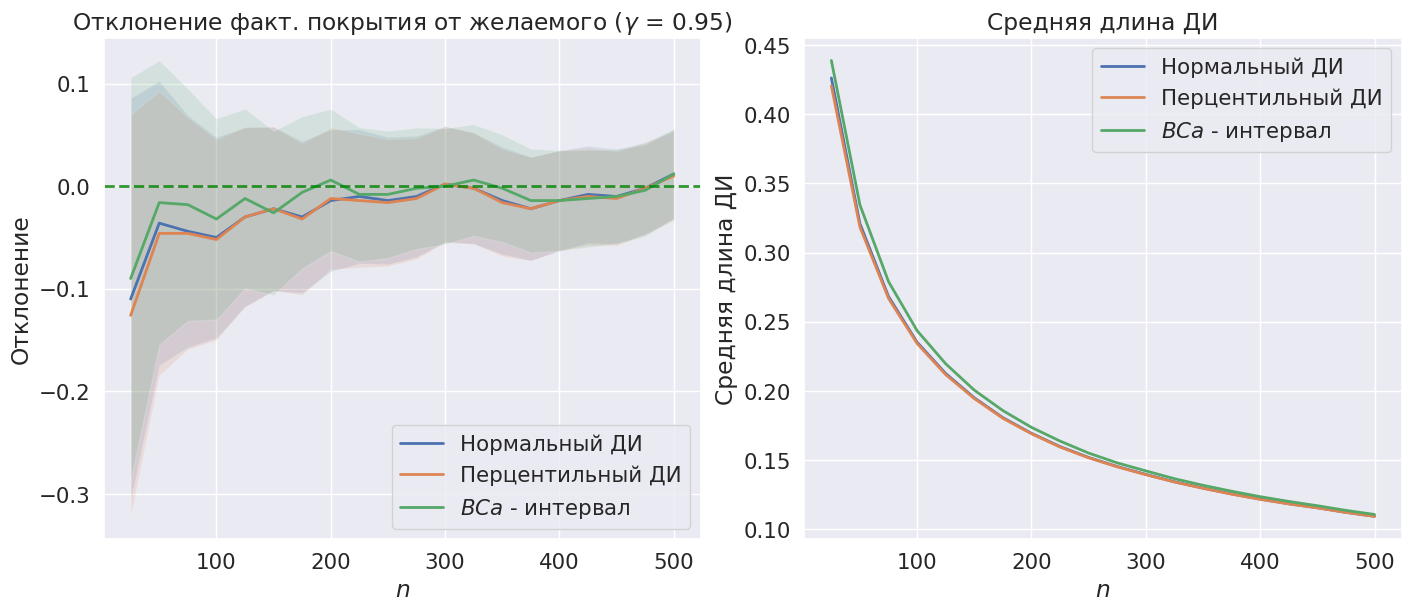

In [ ]:
plt.figure(figsize=(9,18))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

labels = ["Нормальный ДИ", "Перцентильный ДИ", r"$BCa$ - интервал"]
for i in range(3):
    ax1.plot(sample_size_grid, rejects[:, i], lw=2, label=labels[i])
    # ДИ, идентичные предыдущим:       k / n         - 1.96 / 2 / n                ** 0.5
    ax1.fill_between(sample_size_grid, rejects[:, i] - 1.96 / 2 / sample_size_grid ** 0.5, rejects[:, i] + 1.96 / 2 / sample_size_grid ** 0.5, alpha=0.15)

ax1.axhline(0, lw=2, ls="--", color="green", alpha=0.8)
ax1.set_xlabel(r"$n$"); ax1.set_ylabel(r"Отклонение")
ax1.set_title(r"Отклонение факт. покрытия от желаемого ($\gamma$ = 0.95)"); ax1.legend(loc="best")


[ax2.plot(sample_size_grid, lengths[:, i], lw=2, label=labels[i]) for i in range(3)]
ax2.set_xlabel(r"$n$"); ax2.set_ylabel(r"Средняя длина ДИ")
ax2.set_title(r"Средняя длина ДИ"); ax2.legend(loc="best")

plt.show()


<font color='red'>
Тут снова неправильно посчитаны доверительные интервалы для уровня доверия. Они ведь должны зависеть не от размера выборки, а от количества выборок
<b><br>
Штраф 1 балл
</color>

Проанализируйте полученную картину и сделайте вывод.

<font color="#ae69c9ff">

_Мне не нравится результат, не очевидно, как так вышло_

Выводы:
- Андрей Куссев на лекции сказал, что BCa должен сходиться, как 1/n, но я этого не наблюдаю. Вот именно здесь "не нравится". Он для меня не очевиден. Есть предположение, что виной тому малый размер выборки и выбранное распределение. Ошибки в методе быть не должно, ибо реализация библиотечная
- Все оценки дисперсии ошибаются скорее в минус, чем в плюс, хотя BCa ошибается всё-таки меньше из-за особенности построения
- Метод оценки через BCa прям хорош, но его проблема в длительности работы. Если первые интервалы должны считаться каждый за O(Bn), то последний работает O(Bn^2) (не бейте, если ошибся, тороплюсь), к сожалению, это должно быть прям плохо на очень большом количестве данных
- Я погонял задание на разных распределениях, взять гамма-распр. - действительно было хорошей идеей. Как раз из-за "сложной" природы распредлеения дисперсия оценивается со смещением

<font color='red'>
Мб стоило взять меньше максимальный размер выборки и больше выборок, тогда в первом графике было бы более ясно видна сходимость
</color>

<font color='green'><b>
Итог: 9 баллов
</color>

## Задача 3

Эта задача посвящена *робастному* оцениванию. Это такой раздел статистики, который изучает, как сильно оценки зависят от выбросов и других *неверных* данных и как построить оценки, которые выдерживают шумы.

В этой задаче Вам предстоит:
- Научиться анализировать поведение простых оценок для распределений с "тяжёлыми хвостами" или при наличии выбросов и аномалий
- Изучить трейдофф между точностью и устойчивостью
- Научиться строить робастные оценки


Далее для всех графиков в этом задании используйте обозначенные цвета для каждого из распределений (даже если графики будут на разных осях). То есть если график касается нормального распределения, то рисуйте его синим цветом.

1) Постройте график теоретической плотности распределения для нормального распределения, распределения Лапласа и распределения Коши (во всех случаях неизвестным параметром является **сдвиг**.

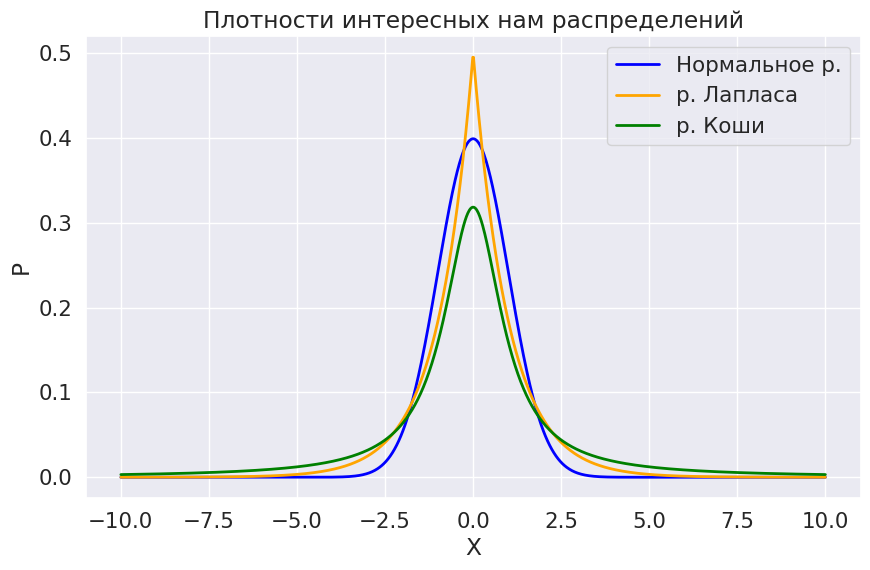

In [ ]:
grid = np.linspace(-10, 10, 1000)

plt.figure(figsize=(10,6))
distrs = [sps.norm, sps.laplace, sps.cauchy]
labels = ["Нормальное р.", "р. Лапласа", "р. Коши"]
c = ["blue", "orange", "green"]
[plt.plot(grid, distrs[i].pdf(grid), lw=2, c=c[i], label=labels[i]) for i in range(3)]
plt.title("Плотности интересных нам распределений")
plt.xlabel("X"); plt.ylabel("P"); plt.legend(loc="best")

plt.show()

2) Сгенерируйте по одной выборке достаточно большого размера из каждого распределения. Мы будем оценивать параметр сдвига каждого из распределений. Сделайте предположение о том, для каких распределений параметр сдвига будет оценён точнее при помощи среднего и медианы. Докажите Ваши предположения экспериментально. Моделировать оценки в этот раз не нужно, достаточно по одной выборке произвести оценивание и проверить его точность.

**Ответ:**

<font color="#ae69c9ff">

Предположение: точность нахождения параметров будет слоедующей: нормальное > Лапласа > Коши. Я делаю такое предположение, основываясь на том, что большая "масса", сосредоточенная на хвостах вносит больший разброс в оценку.
Кроме того, с лекции Виталия Пыреэу, мы знаем, что оценка средним при добавлении даже одного выброса сильно сбивается. Получается, скорее всего, оценки сдвига медианой дадут лучший результат.

In [ ]:
N = 10000
[print("Ошибка предположения для оценки средним " + labels[i] + ": " + str(abs(np.mean(distrs[i].rvs(size=N, random_state=seed)))) +
       ". Ошибка для оценки медианой: " + str(abs(np.median(distrs[i].rvs(size=N, random_state=seed))))) for i in range(3)]

Ошибка предположения для оценки средним Нормальное р.: 0.0021359833684262116. Ошибка для оценки медианой: 0.0025949757928775408
Ошибка предположения для оценки средним р. Лапласа: 0.027831411888760205. Ошибка для оценки медианой: 0.015055533262694076
Ошибка предположения для оценки средним р. Коши: 5.056137830903064. Ошибка для оценки медианой: 0.02347635228771081


[None, None, None]

<font color="#ae69c9ff">

Ну, предположение было опредлённо хорошим, но оно не учитывало, насколько хорошее нормальное распределение. Из-за сверхлёгких хвостов мы получили более точную оценку средним, чем медианой. По остальным - как и предсказано.

3) Часто в реальной жизни мы сталкиваемся с данными, в которых есть выбросы, возникшие, например, из-за опечаток. Пусть в выборке содержится 99 точек на интервале $[0;1]$ и один элемент, равный 300. Тогда среднее значение нашей выборки будет не меньше трех. Ясно, что так дело не пойдет, что же делать?

Можно использовать медиану или **усеченное среднее**.

**Усеченное среднее порядка $\alpha$** -- это среднее, составленное из выборки, от которой отрезаны $\alpha$- и $(1 - \alpha)$-квантили. Как ее получить?


1.   Отсортировать выборку
2.   Отрезать первые и последние ($\alpha \cdot \text{размер выборки}$) элементов выборки
3.   Посчитать среднее оставшихся значений

Напишите функцию для подсчёта этой статистики. Посчитайте усечённое среднее для сгенерированных выше выборок, но разных $\alpha$ и визулизируйте полученные значения. Оцените и изобразите распределение оценок для распределений выше и разных альфа. Как оно изменяется?

<font color="#ae69c9ff">

_Пожалуйста, попросите автора не противоречить себе в условии заданий. Звучит странно: 2: "...по одной выборке...", 3: "...распределение оценок для распределений выше...", так где одна выборка, а где много?_

_Я блоюсь Виталия Пырэу, поэтому не хочу спрашивать в чате. Виталий, если проверяете Вы - этой ячейки не существует._

<font color='red'>
Запишем.
</color>

In [ ]:
def truncated_means(samples, alpha=0.3):
    return np.mean(np.sort(samples, axis=1)[:, int(alpha * len(samples[0, :])):int((1 - alpha) * len(samples[0, :]))], axis=1)

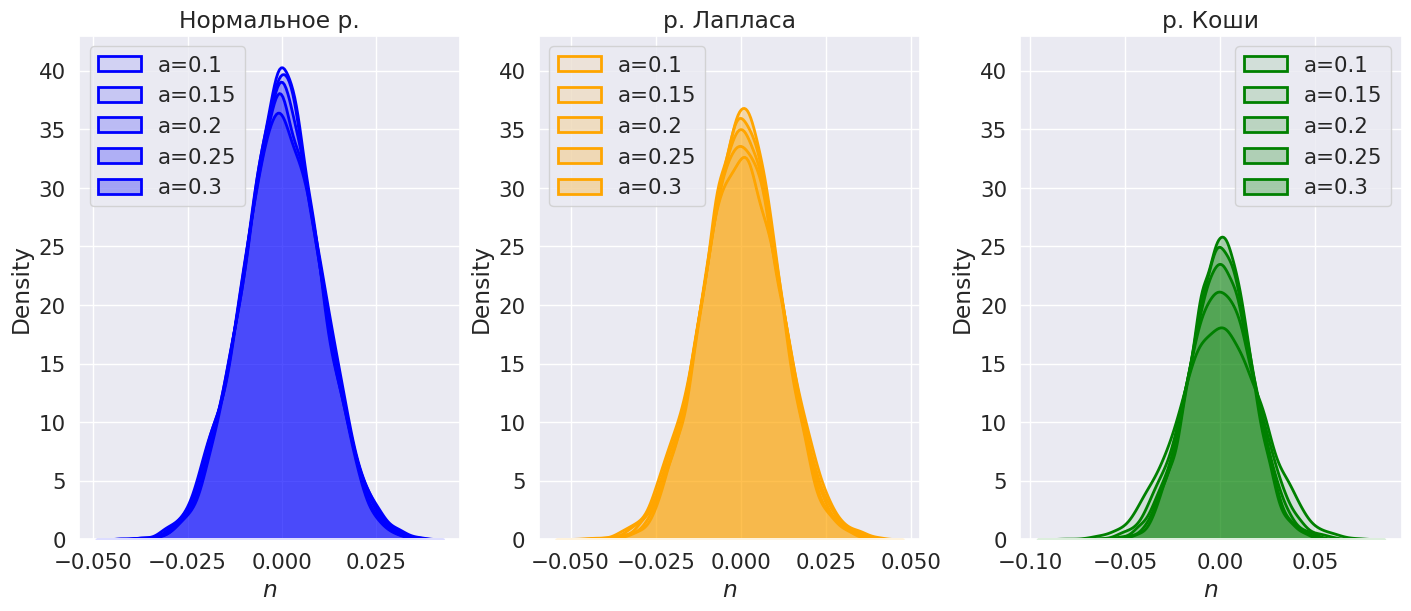

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), constrained_layout=True)
alpha_grid = [0.1, 0.15, 0.20, 0.25, 0.30]

for i in range(3):
    ax = axes.ravel()[i]
    ax.set_ylim(0, 43)
    distr = distrs[i].rvs(size=(5000, N), random_state=seed)
    [sns.kdeplot(truncated_means(distr, alpha_grid[j]), alpha=alpha_grid[j], fill=True, color=c[i], lw=2, label="a=" + str(alpha_grid[j]), ax=ax) for j in range(5)]
    ax.set_xlabel(r"$n$"); ax.legend(loc="best"); ax.set_title(labels[i])

plt.show()

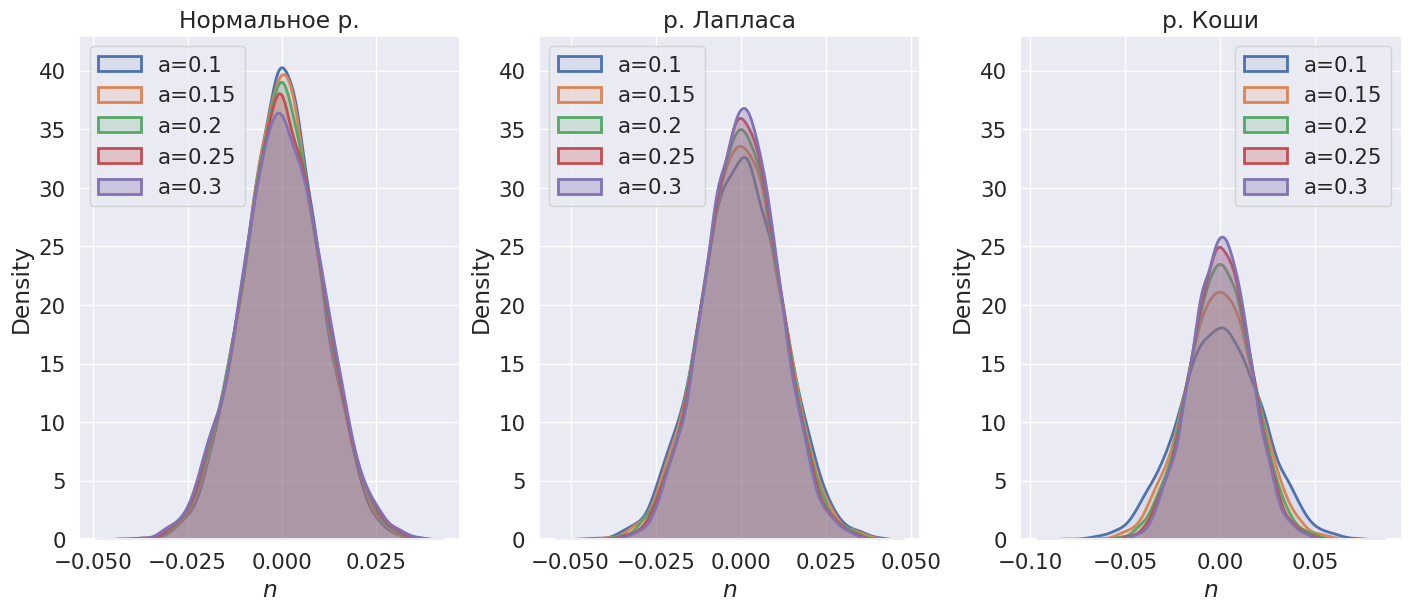

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), constrained_layout=True)

for i in range(3):
    ax = axes.ravel()[i]
    ax.set_ylim(0, 43)
    distr = distrs[i].rvs(size=(5000, N), random_state=seed)
    [sns.kdeplot(truncated_means(distr, alpha_grid[j]), alpha=alpha_grid[j], fill=True, lw=2, label="a=" + str(alpha_grid[j]), ax=ax) for j in range(5)]
    ax.set_xlabel(r"$n$"); ax.legend(loc="best"); ax.set_title(labels[i])

plt.show()

<font color='red'>
Непонятно зачем закрашивать было
</color>

<font color="#ae69c9ff">

Я не умею усидеть на всех стульях разом, поэтому вроде и выполнил требование на персинтентность цветов, и ~~побаловался с красками~~ пренебрёг им, чтобы можно было легко отследить динамику распределения.

Так как интересующим нас параметром по заданию является среднее, а не дисперсия, хочется, чтобы KDE был поуже -> уже можем с кафом оценивать средним. Хорошо видно, что нормальное распредлеление само по себе является хорошим и чем сильнее его обрезаем, тем хуже получаем результат. С распределениями Коши и Лапласа ситуация обратная из-за достаточно тяжёлых хвостов.

4) Постройте график квадрата разности каждой из оценок и истинного значения параметра в зависимости от роста размера выборки для разных $\alpha$. Сделайте выводы, какие оценки точнее.

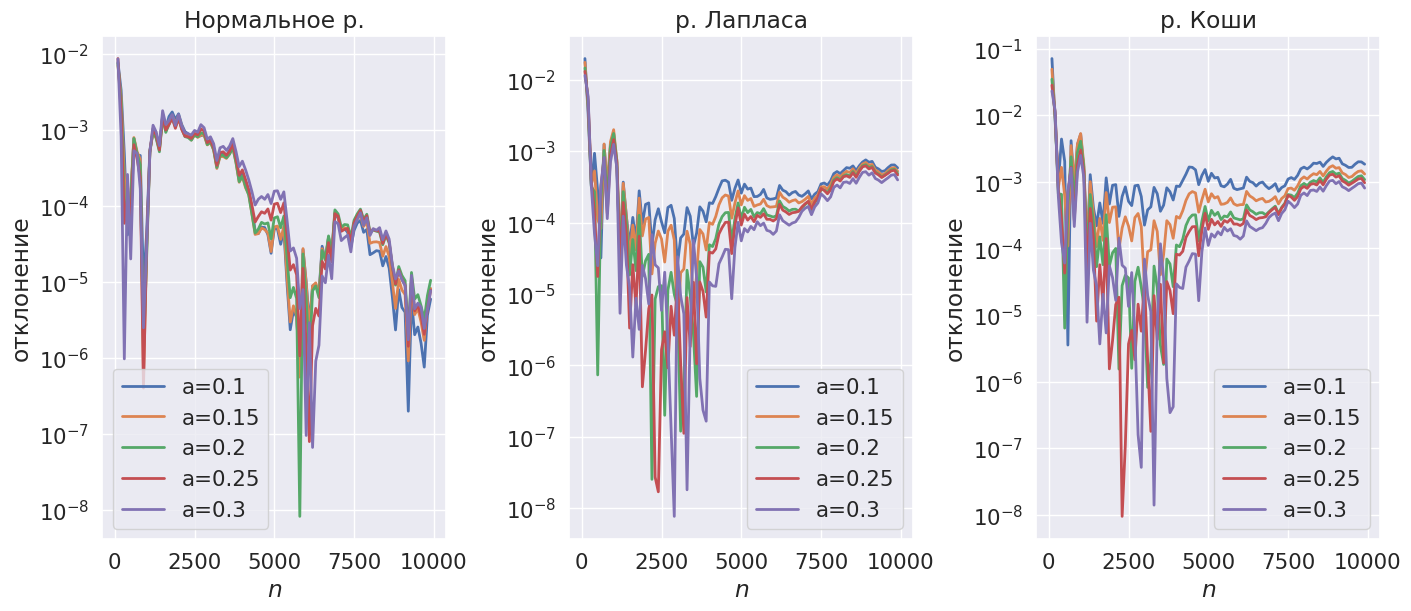

In [ ]:
sample_size_grid = np.arange(100, N, 100)
dists  = [sps.norm, sps.laplace, sps.cauchy]

fig, axes = plt.subplots(1, 3, figsize=(14, 6), constrained_layout=True)

for i in range(3):
    ax = axes.ravel()[i]
    distr = distrs[i].rvs(size=(1, N), random_state=seed)
    [ax.plot(sample_size_grid, (0 - np.asarray([truncated_means(distr[:, :k], alpha_grid[j]) for k in sample_size_grid])) ** 2, lw=2, label="a=" + str(alpha_grid[j])) for j in range(5)]
    ax.set_xlabel(r"$n$"); ax.set_yscale("log"), ax.set_ylabel("отклонение"), ax.legend(loc="best"); ax.set_title(labels[i])

plt.show()

<font color='red'>
Тут можно было бы рисовать не для одной траектории, а усреднить, тогда были бы красивые графики
</color>

<font color="#ae69c9ff">

Для нормального распределения опять всё нормально: и оценка убывает, как 1/n, и наименьшее отклонение достигается при a=0.1. Для распределений Коши и Лапласа - ну... Сходимость ведёт себя как-то странно после n=2000 _(вот бы можно было просто обрезать график и забить на это, сказав, что всё хорошо)_, а наилучшая оценка достигается при большем a. Однако лучше она не на порядок, а чуть-чуть. Зато это даёт нам знание, что можно ~~выкинуть примерно половину данных распредления~~ избавиться от выбросов и всё будет хорошо.

Вообще, как я узнал с курса по машинке, сейчас нет особо проблем с малым количеством данных, со слов Нейчева часто приходится именно что уменьшать размер выборки. Поэтому знание о том, что для распределений с тяжёлыми хвостами его можно уменьшать настолько сильно несёт в себе практический смысл.

👍

**Теорема**
Пусть распределение симметрично относительно нуля и имеет одну моду в нуле, тогда асимптотическая дисперсия усеченного среднего порядка $\alpha$ может быть выражена по формуле:
$$
\sigma^2(\alpha) = 2\cdot\frac{\int_0^{u_{1 - \alpha}} x^2 dF(x) + \alpha\cdot(u_{1 - \alpha})^2}{(1 - 2\alpha)^2},
$$

где $u_\alpha$ – квантиль порядка $\alpha$ распределения $F$.

Вычислите дисперсию и постройте график дисперсии в зависимости от $\alpha$. \\\\ Виталий в чате сказал: построение - скип. Это в следующем пункте будет

*Подсказка.* Для численного интегрирования используйте функцию `quad` из модуля `scipy.integrate`

In [ ]:
def sel_div_str(distr, alpha):
    I, _ = quad(lambda x: x ** 2 * distr.pdf(x), 0, distr.ppf(1 - alpha))
    return 2 * (I + alpha * (distr.ppf(1 - alpha)) ** 2) / (1 - 2 * alpha) ** 2

4.5) Дополнительный пункт на 5 баллов.

Докажите предложенную теорему.

<font color="#ae69c9ff">

На стене в болтае слезами была выведена ссылка на занимательную [статью](https://www.jstor.org/stable/2238195), раз уж нам так повезло её отыскать, изучим и запишем пруф утверждения выше. Мда. Не просто так слезами была выведена... Короче не понравилось) На просторах интернета в таком случае найдём другой пруф, идейно похожий, но немного более простой пруф:

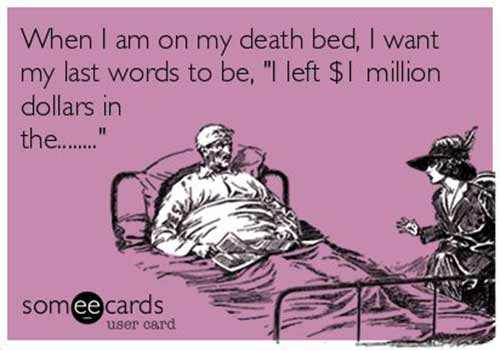

5) Постройте графики для асимптотической дисперсии усечённого среднего в зависимости от $\alpha$ для всех трех распределений на разных осях (используйте `plt.subplots(1, 3, figsize=(21,7))`). Для заголовка графика используйте `ax[i].set_title`, для заголовка всей картинки используйте `fig.suptitle`.

/tmp/ipykernel_35404/514861968.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  return 2 * (I + alpha * (distr.ppf(1 - alpha)) ** 2) / (1 - 2 * alpha) ** 2
/tmp/ipykernel_35404/514861968.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I, _ = quad(lambda x: x ** 2 * distr.pdf(x), 0, distr.ppf(1 - alpha))


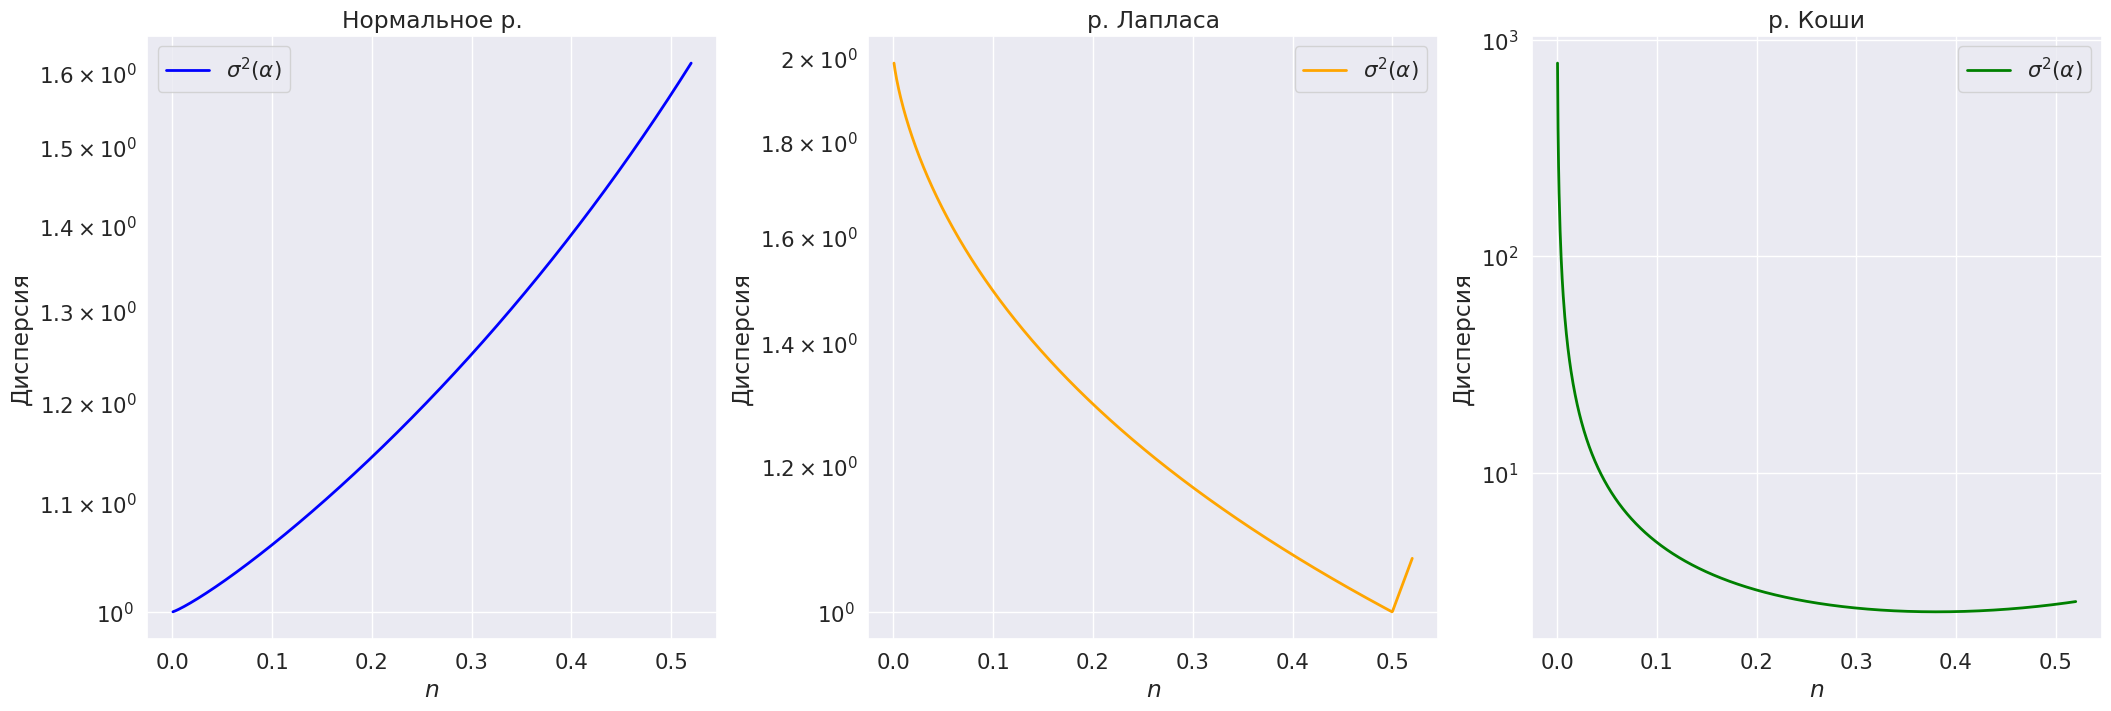

In [ ]:
alpha_grid = np.linspace(0, 0.52, 1000) # Я знаю, что при a=0.5+ результат перестаёт быть коррекным, но в иссл. целдях было интересно
fig, axes = plt.subplots(1, 3, figsize=(21, 7), constrained_layout=True)


for i in range(3):
    ax = axes.ravel()[i]
    ax.plot(alpha_grid, [sel_div_str(distrs[i], a) for a in alpha_grid], lw=2, color=c[i], label=r"$\sigma^2(\alpha)$")
    ax.set_xlabel(r"$n$"); ax.set_yscale("log"), ax.set_ylabel("Дисперсия"), ax.legend(loc="best"); ax.set_title(labels[i])

plt.show()

<font color="#ae69c9ff">

Занимательно, графики описывают примерно то, что я видел до этго в п.3. Утверждается, что нам хочется минимизировать дисперсию, для этого нужно брать как можно брать соответствующие $\alpha$ (см график, тут очев) и искать балланс между ростом/минимизацией дисперсии и потерей значимой части уже корректных данных после исключения выбросов.\
На графиках не видно +inf при $\alpha=0.5$, так как в той точке порядок нуля числителя совпадает со знаменателем.

6) *Breakdown point* в статистике неформально называется такое наименьшее число $x$ от 0 до 1, что если изменить больше $(100\cdot x)\%$ наблюдений выборки на выбросы, то оценка "пойдёт в разнос" и её значение может оказаться сколь угодно большим по модулю, как если бы вся выборка состояла из выбросов (более формальное определение см. на лекции).

Предположите, как Breakdown point усечённого среднего зависит от параметра $\alpha$.

Ответ:

<font color="#ae69c9ff">

Хочется верить, что для усечённого среднего Breakdown point равняется $\alpha$. Предположим, говорящий мета-кот из Рика и Морти нагадил не на пляже во Флориде, а прям знатно так и прямо нам в $\frac{1}{\varepsilon}$ наблюдений, сдедав их равнми +inf (в выборку добавили просто оч оч большие значения), тогда включение хотябы одного из них уже убьёт среднее $\rightarrow$ минимальное $\alpha$ и есть $\varepsilon n$.

Проверьте своё предположение моделированием. Будем считать, что вместо произвольных $(100\cdot x)\%$ выборки будет записано какое-то заранее подобранное достаточно большое число с положительным или отрицательным знаком.

/home/ivan/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivan/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


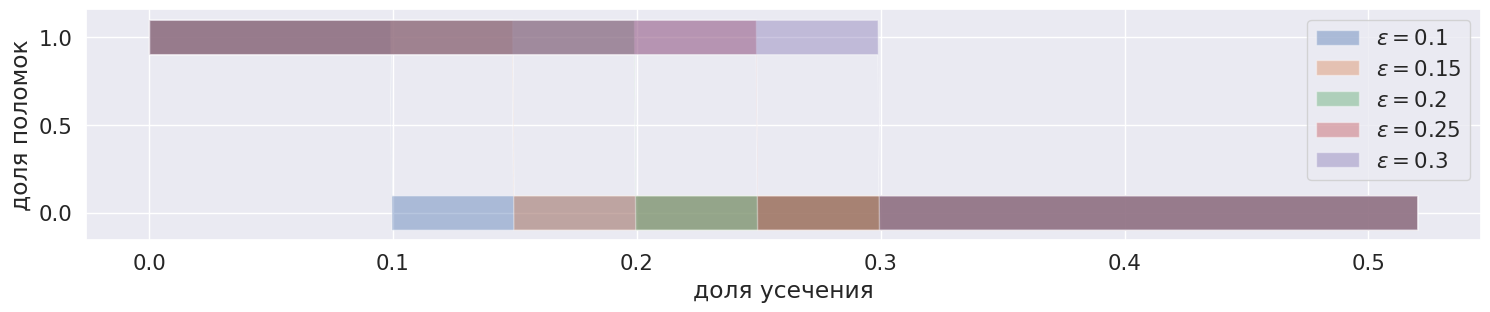

In [ ]:
def truncated_sums(samples, alpha=0.3):
    return np.sum(np.sort(samples, axis=1)[:, int(alpha * len(samples[0, :])):int((1 - alpha) * len(samples[0, :]))], axis=1)


N, n = 100, 1000
samples = sps.uniform(0, 1).rvs(size=(N, n))

sel = [0.1, 0.15, 0.20, 0.25, 0.30]
ans = []
for eps in sel:
    res = []
    samples[:, :int(n*eps)] = np.full((N, int(n*eps)), 10 ** 6)
    for x in alpha_grid:
        k = np.sum(truncated_means(samples, x) > 1)
        res.append((k / N - 1.96 / 2 / N ** 0.5, k / N + 1.96 / 2 / N ** 0.5)) # ДИ, идентичный заданию 1
    ans.append(res)

plt.figure(figsize=(18,3))
[plt.fill_between(alpha_grid, *np.array(ans[i]).T, alpha=0.4, label=fr"$\varepsilon=$" + str(sel[i])) for i in range(len(ans))]
plt.xlabel(r"доля усечения"); plt.ylabel("доля поломок"); plt.legend(loc="best")
plt.show()

<font color='red'>
Я долго пытался понять, что изображено на этой картинке, и не понял... Из игры с цветами можно выйти и проигравшим
<b><br>
Штраф 1 балл
</color>

<font color="#ae69c9ff">

Я не стал добавлять -inf, ибо идейно они буквально ничего не поменяют. Я спецаильно взял не очень узкие ДИ (вернее, малое количество оценок для их полчения), чтобы график был читаем.

Можно сказать, что предположение абсолютно корректно. Явно виден "индикаторный вид" на графике и полное отсутствие намёков на непрерывность

8. Мы знаем, что существует Оценка Максимального Правдоподобия:

$\hat{\theta} = \mathrm{argmin}_{\theta}(-\log f_{\theta}(x))$, $f_{\theta}(x)$ --- правдоподобие выборки. В таком же виде можно выписать и оценки средним, медианой и усечённым средним:

$\hat{\theta} = \mathrm{argmin}_{\theta}(\sum_{i=1}^n\rho(x_i - \theta))$.

В общем случае, такая оценка называется обобщённой оценкой максимального правдоподобия или $M$-оценкой. Функция $\rho$ называется функцией влияния.

1) Как должна выглядеть функция $\rho$, чтобы результатом было усечённое среднее? *Указание*: "усекать" можно не только по квантилю, но и по числу

<font color="#ae69c9ff">

0. Идейно это функция, дающая какое-то усреднение на интересующей нас части выборки (не обязательно центральной) и не учитывающая ничего больше. Можно рассмотреть, как комбинацию 1 и 2 ниже
1. На курсе машинки Нейчева утверждалось, что почти все "хорошие" функции ошибки получаются по ММП, применённому к какому-то распредлеению. Если я правильно понимаю, эта идея пришла из баессовского подхода, и работает она очень даже хорошо
2. Иногда разумно усреднять и по числу. На пракатике я с таким пока не сталкивался, поэтому предложу к рассмотрению очевидный случай: если мы знаем, что какой-то прибор показывает значения только из опр. диапазона, а сзади подкрался кот и нагадил в выборку, то последнее можно отсечь, сославшись на опечатки/ошибки. Здесь мы в явном виде удилили все квантили, выходящие за рамки

2) Эквивалентно задачу оптимизации можно писать в виде системы уравнений $(\sum_{i=1}^n\psi(x_i - \theta)) = 0$. Сравните два определения и скажите, какое из них шире (определяет больше возможных оценок) и как они связаны.

<font color="#ae69c9ff">

Вероятно, автор предполагает, что $\psi(...) = \nabla \rho(...)$, да будет так. Мною утверждается, что второе определение много шире первого: под него попадут ещё максимумы, локальные минимумы и области, где $\rho(...)$ константа (не уверен, что они есть, но вроде есть). В общем случае хочется эквивалентности этах условий, она достигается при выпуклости $\rho(...)$.

<font color='red'>
Это правда, что у уравнения с ψ может быть больше решений, чем у соответствующего уравнения с ρ. Но тут спрашивалось про классы оценок, которые в принципе можно задать этими уравнениями, то есть любое ли уравнение, задаваемое через ψ можно задать через ρ. Если какое-то решение ψ соответствует максимуму ρ, то проблем нет, можно взять просто -ρ
</color>

3) Самое интересное. Для распределения Коши постройте M-оценки для разных (хотя бы трёх) функций $\rho$ или $\psi$. Ищите максимум градиентным спуском, а ноль функции --- методом Ньютона.

Примеры функций влияния можно взять вот тут: https://en.wikipedia.org/wiki/Robust_statistics#M-estimators

In [ ]:
def psi_cauchy(X, c): return X / (c * c + X * X)
def dpsi_cauchy(X, c): return (c * c - X * X) / (c * c + X * X) ** 2


def psi_huber(X, c): return np.clip(X, -c, c)
def dpsi_huber(X, c): return (np.abs(X) <= c).astype(float)


def psi_tukey(X, c):
    U = X / c
    m = np.abs(U) < 1
    Y = np.zeros_like(X)
    Y[m] = X[m] * (1 - U[m] ** 2) ** 2
    return Y

def dpsi_tukey(X, c):
    U = X / c
    m = np.abs(U) < 1
    Y = np.zeros_like(X)
    Y[m] = (1 - U[m] ** 2) ** 2 - 4 * (X[m] ** 2) / (c * c) * (1 - U[m] ** 2)
    return Y


def gd(theta, X, psi, c, lr=0.1, it=500, prec=1e-8): # благо на метоптах научили писать град. спуск; было проще самому, чем изучать функцию
    th = theta
    for _ in range(it):
        g = -np.mean(psi(X - th, c))
        th -= lr * g
        if abs(g) < prec: break
    return th


def newton(theta, X, psi, dpsi, c, it=500, prec=1e-6):
    th = theta
    for _ in range(it):
        r = X - th
        num, den = np.sum(psi(r, c)), np.sum(dpsi(r, c))
        if abs(num) < prec or den == 0: break
        th += num / den
    return th


In [ ]:
n = 1000
X = sps.cauchy(loc=0, scale=4).rvs(n, random_state=seed)
theta = np.median(X)

th_mle = gd(theta, X, psi_cauchy, 1)
th_huber = gd(theta, X, psi_huber,  1.345)
th_tukey = gd(theta, X, psi_tukey,  4.685)

print("th_mle:", th_mle)
print("th_huber:", th_huber)
print("th_tukey:", th_tukey)
print()

th_newton_mle = newton(theta, X, psi_cauchy, dpsi_cauchy, 1)
th_newton_huber = newton(theta, X, psi_huber,  dpsi_huber,  1.345)
th_newton_tukey = newton(theta, X, psi_tukey,  dpsi_tukey,  4.685)

print("th_newton_mle:", th_newton_mle)
print("th_newton_huber:", th_newton_huber)
print("th_newton_tukey:", th_newton_tukey)

th_mle: 0.10104812755198761
th_huber: -0.1369004753122972
th_tukey: 0.07787712024700415

th_newton_mle: 0.12369360289581305
th_newton_huber: -0.1369050258110831
th_newton_tukey: 0.0794838134746319


3.5) Выразите усечённое среднее как L-оценку. Сравните усечённое среднее с его "винзоризованной" версией: в начале все элементы, большие $1-\alpha$-квантиля заменяем на значение этого квантиля (так же для меньших $\alpha$-квантиля) и затем усредняем. В этой оценке предлагается не выкидывать аномалии, а обрезать их. Предложите свои 1-2 L-оценки и сравните их с нашими.

Ответ:

In [ ]:
def L(X, a): return np.mean(np.sort(X)[int(a * len(X)) : len(X) - int(a * len(X))])

def wmean(X, a):
    q1, q2 = np.quantile(X, [a, 1 - a])
    return np.mean(np.clip(X, q1, q2))


def trimean(X):
    q1, med, q3 = np.quantile(X, [0.25, 0.5, 0.75])
    return (q1 + 2 * med + q3) / 4

4) Сравните (по точности предсказания) результаты, полученные для распределения Коши и разных функций влияния, а также для всех L-оценок.

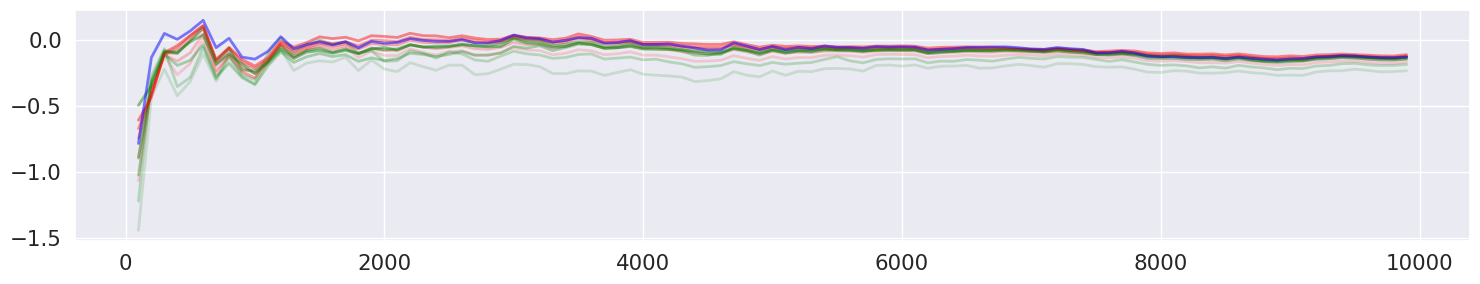

In [ ]:
n = 10000
X = sps.cauchy(loc=0, scale=4).rvs(n, random_state=seed)
sample_size_grid = np.arange(100, n, 100)

ests  = [L, wmean, trimean]
sel = [0.1, 0.15, 0.20, 0.25, 0.30]

col = ["red", "green"]
labels = ["L-среднее", "Среднее вензированное"]
plt.figure(figsize=(18,3))
[[plt.plot(sample_size_grid, [ests[i](X[:N], a) for N in sample_size_grid], lw=2, c=col[i], alpha=a * 1.5, label=labels[i] + ", a = " + str(a)) for i in range(2)] for a in sel]
plt.plot(sample_size_grid, [ests[2](X[:N]) for N in sample_size_grid], lw=2, c="blue", alpha=0.5, label="Оценка Тьюки")
plt.show() # немного не успел дописать. Утв.: очень плохо сосредотачивать массу на краях, но вроде бы от этого мир не рушится.

5) Оцените Breakdown point предложенных оценок. Сравните результаты с теоретическими (см. лекцию). Сделайте вывод о том, как взаимосвязаны точность оценки и Breakdown point.

BP(trim) = BP(vin) = $\alpha$

Сделайте единый вывод о робастном оценивании:

<font color="#ae69c9ff">


Робастные оценки очень хороши для выборки с выбросами, они позволяют исключить последние из рассмотрения без существенного вреда результату

<font color='red'>
Последние пункты недоделаны(
<b><br>
Штраф 3 балла
</color>

<font color='green'>
<b>
Итог: 6 баллов
</color>

<font color='green'>
Очень крутая работа, жаль что не хватило времени доделать. Если остались вопросы, пишите в тг @grisha_kazachonok
</color>

## Задача 4

И снова, реальные данные.

В этой задаче Вам предстоит применить на практике все изученные выше методы построения доверительных интервалов и робастных оценок.

Мы проанализируем изменение индекса качества воздуха (air quality index, AQI) для двух мегаполисов Индии за последние годы. Данные взяты с Kaggle (https://www.kaggle.com/rohanrao/air-quality-data-in-india)

In [ ]:
!gdown https://drive.google.com/file/d/1hvODMPkJPe0HLIGq8RgClN1_RSw2gfD-

/bin/bash: line 1: gdown: command not found


1. Загрузите файл `city_day.csv`. Нам понадобятся столбцы `City`, `Date` и `AQI`. При этом учтите, что:
* В дальнейшем мы будем работать с датами, поэтому используйте аргумент `parse_dates` чтобы корректо их распарсить
* Данные содержат пропуски, которые нужно удалить

Для удобства сохраните в отдельные поля `Month` и `Year` соответственно год и месяц, когда производились замеры

Нас будут интересовать два города: Мумбаи (Mumbai) и Калькутта (Kolkata). Сохраните данные по этим двум городам для всех дней с 1 июля 2018 года включительно

2. Изучите выборки значения **AQI** для месяцев с июля 2018-го по июнь 2020-го годов на предмет наличия аномалий или выбросов и предложите хорошую оценку для "среднего значения" этого распределения. Это не обязательно должно быть среднее по выборке. Визуализируйте оценки для каждого города и месяца в удобном виде и сделайте по ним выводы.

Для каждого месяца с июля 2018 по июнь 2020 включительно постройте бутстрепный доверительный интервал для __среднего значения AQI__. Тип интервала выберите сами, например, изучив распределение среднегомесячного значения по данным до июля 2018 года или на основании результатов задачи 2. Учтите: на этот раз реализовать интервал нужно **самостоятельно**.

Постройте на одном графике доверительные интервалы для Мумбаи и Калькутты. Также отметьте точками на графике истинный средний AQI и соедините точки линиями. Проследите за тем, чтобы графики, относящиеся к одному городу, были одного цвета.

Посмотрите на получившийся график. Видны ли в нем какие-либо закономерности? С чем они могут быть связаны?

Вывод:

4. Теперь давайте сравним качество воздуха в апреле 2019 и апреле 2020 годов. Постройте __на одном графике__
* доверительные интервалы для апреля 2019 и апреля 2020 для Мумбаи
* истинные средние значения (с помощью `plt.hlines`)

Проследите за тем, чтобы графики, относящиеся к одному городу, были одного цвета.

Сделайте выводы. Что можно сказать про доверительные интервалы в каждом из случаев? Какие прикладные выводы о загрязнении воздуха можно сделать из Ваших результатов? Подумайте о том, почему некорректно делать выводы о том, где чище воздух только исходя из сравнения оценок показателей качества, и приходится сравнивать интервалы.